In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import geopandas as gpd
import matplotlib.pyplot as plt
import warnings
from matplotlib.colors import ListedColormap

import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dropout

from tensorflow.keras.regularizers import l1, l2

In [2]:
poa = gpd.read_file("Shape\poa_selected.gpkg")
sa1 = gpd.read_file("Shape\sa1_to_poa.gpkg")
sa1 = sa1[["SA1_CODE21", "POA_CODE21", "geometry"]]
poa = poa[["POA_CODE21", "geometry"]]

In [3]:

# Import Rego Data 
rego = pd.read_csv("Data\poa_ev.csv")
# Import synthetic populaiton
synthetic = pd.read_csv("Data\clean1.1_data.csv")
synthetic["SA1"] = synthetic["SA1"].astype(str)
synthetic_merged = sa1.merge(synthetic, left_on="SA1_CODE21", right_on="SA1", how="inner")

In [4]:
rego["POA_CODE21"] = rego["POA_CODE21"].astype(str)
total_evs = synthetic_merged.merge(rego, left_on="POA_CODE21", right_on="POA_CODE21", how="inner").drop_duplicates(subset=["POA_CODE21"])
total_evs = total_evs[["POA_CODE21", "SA1_CODE21", "TOTAL1"]]

In [5]:
categorical_columns = ["dwelltype_Flat or Apartment", "dwelltype_Other", "dwelltype_Separate House", "dwelltype_Terrace/Townhouse",
                       "owndwell_Being Purchased", "owndwell_Being Rented", "owndwell_Fully Owned", "owndwell_Occupied Rent-Free", "owndwell_Something Else"]

hist_values = []
num_bins = 10 
labels = []

inc_bins = [-1, 0, 149, 299, 399, 499, 649, 799, 999, 1249, 1499, 1749, 1999, 2499, 2999, 3499, 3999, 4499, 4999, 5999, 7999, np.inf]
hhsize_bins = [1, 2, 3, 4, 5, 6, 7, np.inf]
vehs_bins = [-1, 0, 1, 2, 3, np.inf]

postcodes = total_evs.merge(synthetic_merged, left_on="POA_CODE21", right_on="POA_CODE21", how="right").dropna()["POA_CODE21"].unique()

for postcode in postcodes:
    hist_values_postcode = []
    selected = synthetic_merged[synthetic_merged["POA_CODE21"] == postcode]

    hist, _ = np.histogram(selected["INC"], bins=inc_bins)
    hist_values_postcode.extend(hist)

    hist, _ = np.histogram(selected["TOTALVEHS"], bins=vehs_bins)
    hist_values_postcode.extend(hist)

    hist, _ = np.histogram(selected["HHSIZE"], bins=hhsize_bins)
    hist_values_postcode.extend(hist)
    
    categorical_sums = selected[categorical_columns].sum().values
    hist_values_postcode.extend(categorical_sums)

    hist_values.append(hist_values_postcode)
    labels.append(rego[rego["POA_CODE21"] == postcode]["TOTAL1"].values[0])

data = np.array(hist_values)
labels = np.array(labels)

In [6]:
# Assuming synthetic_merged is your DataFrame
# plt.hist(synthetic_merged[synthetic_merged["SA1"] == "20301103507"]["INC"], bins=inc_bins, edgecolor='k')
# plt.xlabel("Income (INC)")
# plt.ylabel("Frequency")
# plt.title("Histogram of Income (INC) with 10 Bins")

# plt.show()

# plt.hist(synthetic_merged[synthetic_merged["SA1"] == "21402159223"]["TOTALVEHS"], bins=vehs_bins, edgecolor='k')
# plt.xlabel("Income (INC)")
# plt.ylabel("Frequency")
# plt.title("Histogram of Income (INC) with 10 Bins")

# plt.show()

In [6]:
data.shape

(281, 42)

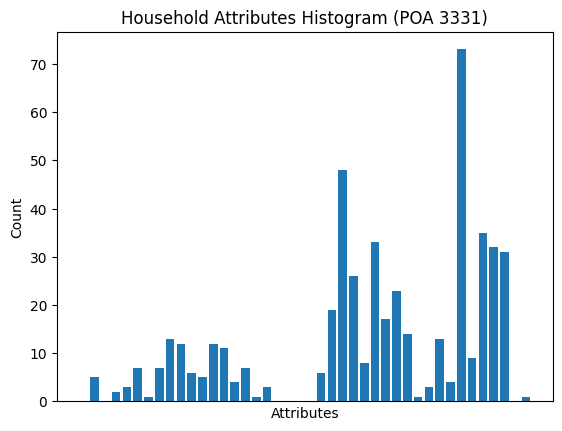

In [19]:
import matplotlib.pyplot as plt



plt.bar(range(len(data[0])), data[0])  # Use indices as x-axis values

# Add labels and title
plt.xlabel("Attributes")
plt.ylabel("Count")
plt.title("Household Attributes Histogram (POA 3331)")
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
# Show the plot
plt.show()

1/1 [==============================] - 0s 20ms/step - loss: 39.2439 - mean_absolute_error: 6.5345
Test loss: [39.24391174316406, 6.534495830535889]


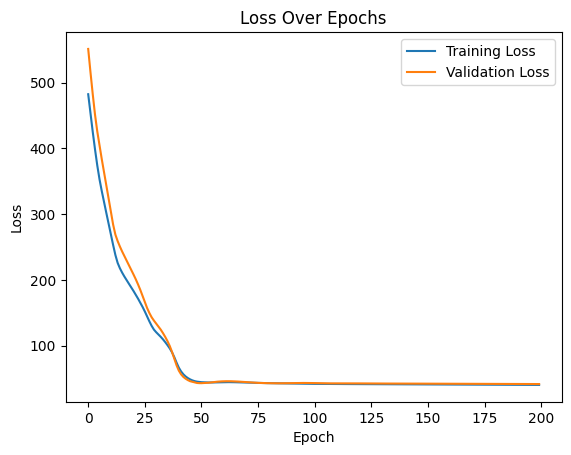

9/9 [==============================] - 0s 875us/step


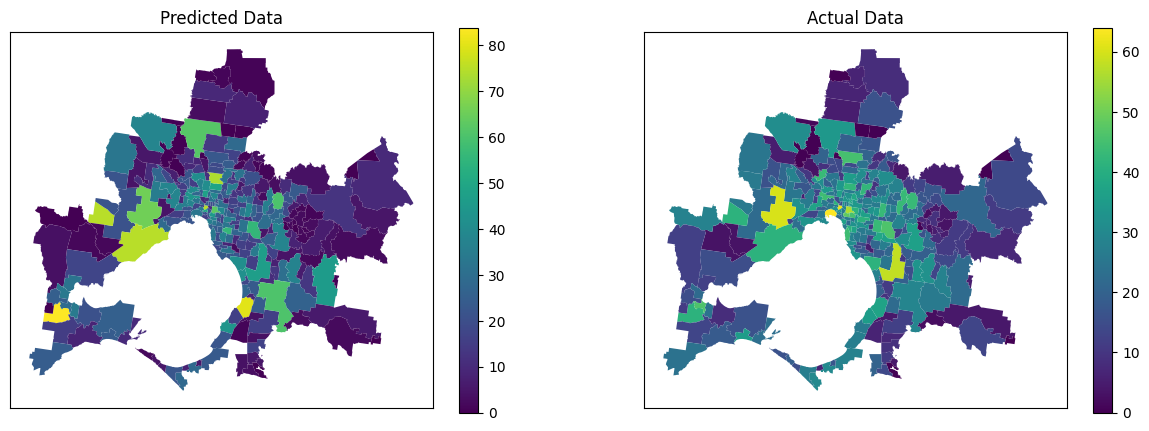

6215.0 5608.3687
0.0 0.0


In [20]:
# Split your data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Define the noise level and create augmented data
noise_level = 0.05
augmented_X_train_list = []
augmented_y_train_list = []

for _ in range(1):
    X_train_noise = noise_level * np.random.randn(X_train.shape[0], X_train.shape[1])
    y_train_noise = noise_level * np.random.randn(y_train.shape[0])
    
    augmented_X_train = X_train + X_train_noise
    augmented_y_train = y_train + y_train_noise
    
    augmented_X_train_list.append(augmented_X_train)
    augmented_y_train_list.append(augmented_y_train)

# Concatenate the augmented data
X_train_augmented = np.concatenate(augmented_X_train_list, axis=0)
y_train_augmented = np.concatenate(augmented_y_train_list, axis=0)

# Define a custom loss function
def custom_loss(y_true, y_pred):
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    penalty = tf.reduce_mean(tf.square(tf.maximum(0.0, -y_pred)))
    total_loss = mse + penalty    
    return total_loss

# Initialize the MLP model
continue_training = True

while continue_training:
    # Initialize a new model instance
    mlp_model = Sequential([
        Dense(128, activation='relu', input_shape=(data.shape[1],), kernel_regularizer=tf.keras.regularizers.l1(0.02)),  # Add L1 regularization
        # Dropout(0.5),  # Add dropout layer with a dropout rate
        Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.01)),
        Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.01)),
        Dense(64, activation='relu'), 
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(16, activation='relu'),
        Dense(8, activation='relu'),
        Dense(1)
    ])

    # Compile the new model
    optimizer = Adam(learning_rate=5e-5)
    mlp_model.compile(optimizer=optimizer, loss='mean_absolute_error', metrics=['mean_absolute_error'])

    # Train the model
    history = mlp_model.fit(X_train_augmented, y_train_augmented, epochs=200, batch_size=X_train_augmented.shape[0], validation_data=(X_val, y_val), verbose=0)
    
    # Make predictions on the test set
    predictions = mlp_model.predict(X_test)
    
    # Check if there are any negative predictions
    # if np.any(predictions < 0):
    #     print("Model predicted negative numbers. Retraining...")
    #     continue_training = True
    # else:
    #     print("Model did not predict negative numbers. Stopping training.")
    continue_training = False

# Evaluate the model on the test set
loss = mlp_model.evaluate(X_test, y_test)
print("Test loss:", loss)

# Plot and save the learn plot
learn_plot = plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.show()

# Make predictions on the entire dataset
predicted = mlp_model.predict(data)

# Add predictions to your data frame
total_evs["pred"] = predicted

# Merge dataframes and handle missing values
pred_poa = poa.merge(total_evs, left_on="POA_CODE21", right_on="POA_CODE21", how="outer")
pred_poa.loc[pd.isna(pred_poa["TOTAL1"]), "TOTAL1"] = 0
pred_poa.loc[pd.isna(pred_poa["pred"]), "pred"] = 0

# Plot the predicted and actual data
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
pred_poa.plot(column="pred", ax=axes[0], legend=True, cmap='viridis')
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].set_title("Predicted Data")

pred_poa.plot(column="TOTAL1", ax=axes[1], legend=True, cmap='viridis')
axes[1].set_xticks([])
axes[1].set_yticks([])
axes[1].set_title("Actual Data")

plt.show()

# Print sums of total values and min values
print(pred_poa["TOTAL1"].sum(), pred_poa["pred"].sum())
print(pred_poa["TOTAL1"].min(), pred_poa["pred"].min())


In [112]:
# training_loss = history.history['loss']
# validation_loss = history.history['val_loss']
# training_loss_series = pd.Series(training_loss, name='Training Loss')
# validation_loss_series = pd.Series(validation_loss, name='Validation Loss')
# training_loss_series.to_csv("Data/training_loss.csv", index=False)
# validation_loss_series.to_csv("Data/validation_loss.csv", index=False)

In [21]:
mlp_model.save("Data\model_new_hist.h5")

c:\Users\danla\anaconda3\envs\fYP\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 444.9296 - mean_absolute_error: 414.7419 - val_loss: 188.3784 - val_mean_absolute_error: 158.1962
Epoch 2/100
1/1 [==============================] - 0s 27ms/step - loss: 448.5312 - mean_absolute_error: 418.3490 - val_loss: 178.6841 - val_mean_absolute_error: 148.5074
Epoch 3/100
1/1 [==============================] - 0s 28ms/step - loss: 455.8509 - mean_absolute_error: 425.6742 - val_loss: 169.3474 - val_mean_absolute_error: 139.1759
Epoch 4/100
1/1 [==============================] - 0s 28ms/step - loss: 403.7935 - mean_absolute_error: 373.6221 - val_loss: 160.1149 - val_mean_absolute_error: 129.9487
Epoch 5/100
1/1 [==============================] - 0s 27ms/step - loss: 420.2247 - mean_absolute_error: 390.0586 - val_loss: 151.4157 - val_mean_absolute_error: 121.2547
Epoch 6/100
1/1 [==============================] - 0s 27ms/step - loss: 388.3777 - mean_absolute_error: 358.2167 - val_loss: 143.2431 - val_mean_absolut

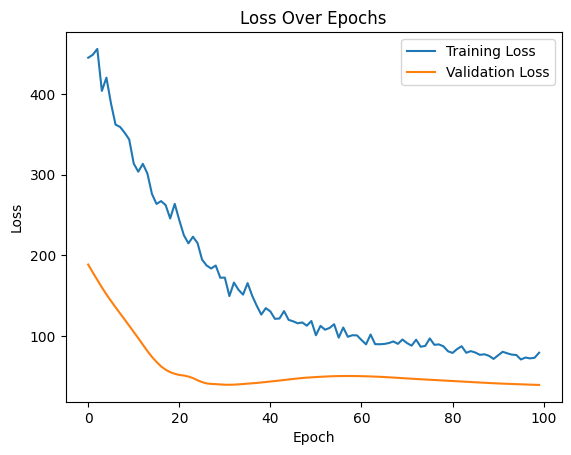

9/9 [==============================] - 0s 2ms/step


,POA_CODE21,SA1_CODE21,TOTAL1,pred
0,3331,20301103507,11.0,0.156922
99,3217,20301103607,13.0,17.699800
6922,3240,20301103608,8.0,0.478791
7110,3216,20302103701,41.0,77.467430
29395,3220,20302103904,46.0,23.696054
...,...,...,...,...
1885970,3943,21402138327,19.0,3.827991
1886808,3940,21402138402,6.0,11.123084
1888933,3938,21402138409,17.0,5.085976
1890202,3913,21402138506,7.0,4.113584


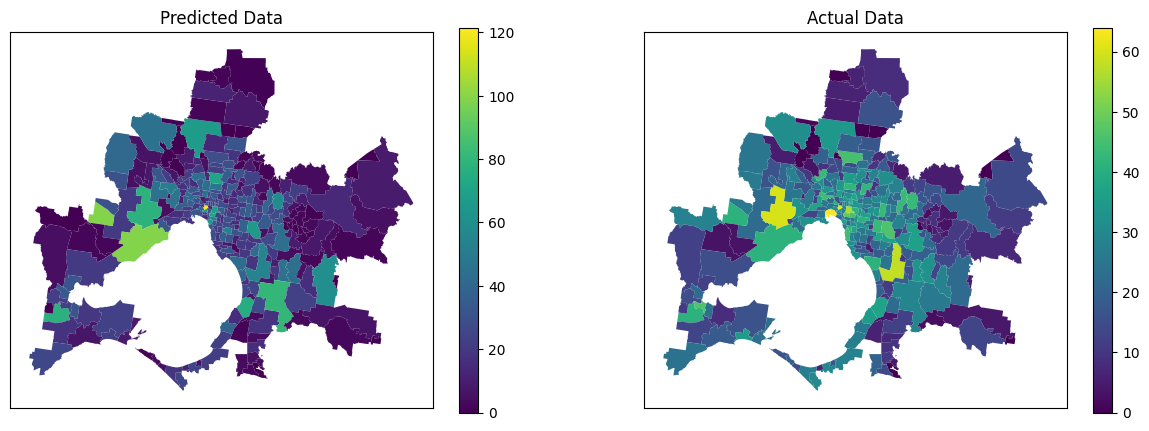

6215.0 6056.118
0.0 0.0


In [9]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


noise_level = 0.05  # Adjust the noise level as needed
augmented_X_train_list = []
augmented_y_train_list = []

for _ in range(1):
    X_train_noise = noise_level * np.random.randn(X_train.shape[0], X_train.shape[1])
    y_train_noise = noise_level * np.random.randn(y_train.shape[0])
    
    augmented_X_train = X_train + X_train_noise
    augmented_y_train = y_train + y_train_noise
    
    augmented_X_train_list.append(augmented_X_train)
    augmented_y_train_list.append(augmented_y_train)

# Concatenate the augmented data
X_train_augmented = np.concatenate(augmented_X_train_list, axis=0)
y_train_augmented = np.concatenate(augmented_y_train_list, axis=0)

def custom_loss(y_true, y_pred):
    # Compute the mean squared error
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    
    # Penalize negative predictions (adjust the penalty weight as needed)
    penalty = tf.reduce_mean(tf.square(tf.maximum(0.0, -y_pred)))
    
    # Combine the MSE and penalty terms (adjust the weighting as needed)
    total_loss = mse + penalty    
    return total_loss

# mlp_model = Sequential([
#     Dense(64, activation='relu', input_shape=(data.shape[1],)),
#     Dense(64, activation='relu'),
#     Dense(64, activation='relu'), 
#     Dense(64, activation='relu'),
#     Dense(32, activation='relu'),
#     Dense(16, activation='relu'),
#     Dense(1)
# ])

mlp_model = Sequential([
        Dense(128, activation='relu', input_shape=(data.shape[1],), kernel_regularizer=tf.keras.regularizers.l1(0.01)),  # Add L1 regularization
        Dropout(0.5),  # Add dropout layer with a dropout rate
        Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.01)),
        Dropout(0.5),
        Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.01)),
        Dense(64, activation='relu'), 
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(16, activation='relu'),
        Dense(8, activation='relu'),
        Dense(1)
    ])

optimizer = Adam(learning_rate=5e-5)

# 'mean_absolute_error'

# Reshape your data to add a channel dimension
# X_train_mlp = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val_mlp = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test_mlp = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# X_train_mlp = X_train_augmented.reshape(X_train_augmented.shape[0], X_train_augmented.shape[1], 1)
# y_train = y_train_augmented
X_train_mlp = X_train
y_train = y_train

continue_training = True

while continue_training:
    mlp_model.compile(optimizer=optimizer, loss='mean_absolute_error', metrics=['mean_absolute_error'])
    # Split your data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.1, random_state=42)

    # Train the model
    history = mlp_model.fit(X_train, y_train, epochs=100, batch_size=X_train.shape[0], validation_data=(X_val_mlp, y_val))
    
    # Make predictions on the test set
    predictions = mlp_model.predict(X_test)
    
    # Check if there are any negative predictions
    if np.any(predictions < -1):
        print("Model predicted negative numbers. Retraining...")
        continue_training = True
    else:
        print("Model did not predict negative numbers. Stopping training.")
        continue_training = False

# Evaluate the model on the test set
loss = mlp_model.evaluate(X_test_mlp, y_test)
print("Test loss:", loss)
learn_plot = plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.savefig('Plots\learn_plot_my_model7.png')
plt.show()



predicted = mlp_model.predict(data)
total_evs["pred"] = predicted
display(total_evs)
pred_poa = poa.merge(total_evs, left_on="POA_CODE21", right_on="POA_CODE21", how="outer")
pred_poa.loc[pd.isna(pred_poa["TOTAL1"]), "TOTAL1"] = 0
pred_poa.loc[pd.isna(pred_poa["pred"]), "pred"] = 0

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
pred_poa.plot(column="pred", ax=axes[0], legend=True, cmap='viridis')
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].set_title("Predicted Data")

pred_poa.plot(column="TOTAL1", ax=axes[1], legend=True, cmap='viridis')
axes[1].set_xticks([])
axes[1].set_yticks([])
axes[1].set_title("Actual Data")

plt.show()
print(pred_poa["TOTAL1"].sum(), pred_poa["pred"].sum())
print(pred_poa["TOTAL1"].min(), pred_poa["pred"].min())


In [47]:
mlp_model.save("Data\my_model7.h5")
plt.savefig('Plots\learn_plot_my_model7.png')

c:\Users\danla\anaconda3\envs\fYP\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


<Figure size 640x480 with 0 Axes>

In [6]:
# # X_train, X_test, y_train, y_test = train_test_split(extended_data, extended_labels, test_size=0.2, random_state=42)
# X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# # Create a CNN model
# # mlp_model = Sequential([
# #     Dense(128, activation='relu', input_shape=(data.shape[1],)),
# #     # Dropout(0.1),  # Add dropout layer with dropout rate of 0.3
# #     Dense(64, activation='relu'),
# #     # Dropout(0.1),
# #     Dense(32, activation='relu'),
# #     # Dropout(0.1),
# #     Dense(1)
# # ])

# mlp_model = Sequential([
#     Dense(128, activation='relu', input_shape=(data.shape[1],)),
#     # Dropout(0.01),  # Add dropout layer with dropout rate of 0.3
#     Dense(256, activation='relu'),
#     # Dropout(0.01),  # Add dropout layer with dropout rate of 0.3
#     Dense(512, activation='relu'),
#     # Dropout(0.01),  # Add dropout layer with dropout rate of 0.3
#     Dense(128, activation='relu'),
#     #Dropout(0.1),  # Add dropout layer with dropout rate of 0.3
#     Dense(64, activation='relu'),
#     # Dropout(0.1),
#     Dense(32, activation='relu'),
#     # Dropout(0.1),
#     Dense(1)
# ])

# def custom_loss(y_true, y_pred):
#     # Compute the mean squared error
#     mse = tf.reduce_mean(tf.square(y_true - y_pred))
    
#     # Penalize negative predictions (adjust the penalty weight as needed)
#     penalty = tf.reduce_mean(tf.square(tf.maximum(0.0, -y_pred)))
    
#     # Combine the MSE and penalty terms (adjust the weighting as needed)
#     total_loss = mse + penalty    
#     return total_loss

# # Compile the model with the specified optimizer and loss function
# optimizer = Adam(learning_rate=5e-6)
# mlp_model.compile(optimizer=optimizer, loss='mean_absolute_error', metrics=['mean_absolute_error'])

# # Reshape your data to add a channel dimension
# X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
# X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# # Train the model
# # while True:
# history = mlp_model.fit(X_train_cnn, y_train, epochs=300, batch_size=X_train.shape[0], validation_split=0.2)
#     # if mlp_model.predict(data).min() > -1 and mlp_model.predict(data).max() < 100:
#     #     break

# # Save the trained model
# mlp_model.save("Data\my_model1.3.h5")

# # Visualize the loss history


# predicted = mlp_model.predict(data)
# print(predicted.min() >= 0)
# # predicted[predicted < 0] = 0
# # rounded_predicted = np.round(predicted).astype(int)
# total_evs["pred"] = predicted
# pred_poa = poa.merge(total_evs, left_on="POA_CODE21", right_on="POA_CODE21", how="outer")
# pred_poa.loc[pd.isna(pred_poa["TOTAL1"]), "TOTAL1"] = 0
# pred_poa.loc[pd.isna(pred_poa["pred"]), "pred"] = 0


# # Plotting
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Loss Over Epochs')
# plt.legend()
# plt.show()

# # Evaluate the model on the test set
# loss = mlp_model.evaluate(X_test_cnn, y_test)
# print("Test loss:", loss)_poa["pred"].max(), pred_poa["TOTAL1"].max())

# fig, axes = plt.subplots(1, 2, figsize=(15, 5))
# pred_poa.plot(column="pred", ax=axes[0], legend=True, cmap='viridis', vmax=max_value)
# axes[0].set_xticks([])
# axes[0].set_yticks([])
# axes[0].set_title("Predicted Data")

# pred_poa.plot(column="TOTAL1", ax=axes[1], legend=True, cmap='viridis', vmax=max_value)
# axes[1].set_xticks([])
# axes[1].set_yticks([])
# axes[1].set_title("Actual Data")

# plt.show()
# print(pred_poa["TOTAL1"].sum(), pred_poa["pred"].sum())
# pred_poa

In [57]:
pred_poa.mean()

C:\Users\danla\AppData\Local\Temp\ipykernel_12572\3876666263.py:1: FutureWarning: The default value of numeric_only in GeoDataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  pred_poa.mean()


POA_CODE21          inf
TOTAL1        20.310458
pred          19.722222
dtype: float64

In [215]:
categorical_columns = ["dwelltype_Flat or Apartment", "dwelltype_Separate House", "dwelltype_Terrace/Townhouse",
                       "owndwell_Being Purchased", "owndwell_Being Rented", "owndwell_Fully Owned", "owndwell_Occupied Rent-Free"]

hist_values = []
num_bins = 10 

sa1_list = synthetic_merged["SA1"].unique()#[:4000]
i = 0

for sa1_selected in sa1_list:
    hist_values_sa1 = []
    selected = synthetic_merged[synthetic_merged["SA1"] == sa1_selected]

    i = i + 1
    if i % 100 == 0:  
        print(i)

    for attribute in ["INC", "TOTALVEHS", "HHSIZE"]:
        hist, _ = np.histogram(selected[attribute], bins=num_bins)
        hist_values_sa1.extend(hist)
    
    categorical_sums = selected[categorical_columns].sum().values
    hist_values_sa1.extend(categorical_sums)

    hist_values.append(hist_values_sa1)

data = np.array(hist_values)


100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900


In [217]:
sa1_pred = mlp_model.predict(data).flatten()
data = {'SA1': sa1_list, 'sa1_pred': sa1_pred}
df = pd.DataFrame(data)
df

374/374 [==============================] - 0s 669us/step


In [219]:
unique_sa1_values  = synthetic_merged[["SA1", "geometry"]].drop_duplicates(subset="SA1")
mysa1_merge = unique_sa1_values.merge(df, on="SA1", how="left")
mysa1_merge.loc[pd.isna(mysa1_merge["sa1_pred"]), "sa1_pred"] = 0
mysa1_merge

In [246]:
pred_sa1_plot = sa1.merge(mysa1_merge[["SA1", "sa1_pred"]], left_on="SA1_CODE21", right_on="SA1", how='left')
pred_sa1_plot.loc[pd.isna(pred_sa1_plot["sa1_pred"]), "sa1_pred"] = 0
pred_sa1_plot

,SA1_CODE21,POA_CODE21,geometry,SA1,sa1_pred
0,20102100908,3340,"MULTIPOLYGON (((144.44381 -37.86401, 144.44362...",NaN,0.000000
1,20102100910,3340,"MULTIPOLYGON (((144.32480 -37.84446, 144.32497...",NaN,0.000000
2,20301103507,3331,"MULTIPOLYGON (((144.24563 -38.01367, 144.24580...",20301103507,0.367945
3,20301103607,3217,"MULTIPOLYGON (((144.29277 -38.26928, 144.29279...",20301103607,0.487588
4,20301103608,3240,"POLYGON ((144.24608 -38.21148, 144.24617 -38.2...",20301103608,0.292830
...,...,...,...,...,...
11946,21402159219,3931,"POLYGON ((145.02982 -38.22619, 145.02947 -38.2...",21402159219,0.175484
11947,21402159220,3931,"POLYGON ((145.03348 -38.23112, 145.03351 -38.2...",21402159220,0.773148
11948,21402159221,3931,"POLYGON ((145.04023 -38.22754, 145.03973 -38.2...",21402159221,0.276295
11949,21402159222,3931,"POLYGON ((145.02819 -38.23559, 145.02932 -38.2...",21402159222,0.308920


<Axes: >

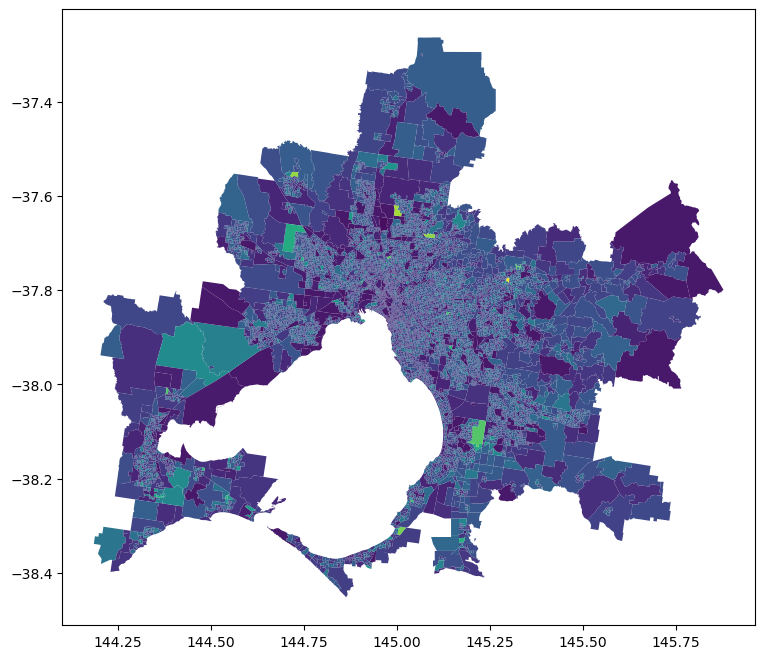

In [250]:
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the GeoDataFrame with the adjusted figure size
pred_sa1_plot.plot(column="sa1_pred", ax=ax)